In [2]:
import warnings # to suppress warnings
import numpy as np # to work with arrays
import pandas as pd # to work with dataframes
import torch # to work with tensors
from IPython.display import Audio # to play audio

import librosa as lb # to work with audio files
from librosa import feature as lbf # to extract features from audio files

import matplotlib.pyplot as plt # to plot graphs
import seaborn as sns # to plot graphs
sns.set(style='dark', palette='bright') # to set style and palette of graphs

from sklearn.model_selection import train_test_split # to split data into train and test sets
from sklearn.pipeline import Pipeline # to create a pipeline of transformers
from sklearn.compose import ColumnTransformer # to preprocess columns of a dataframe
from sklearn.base import BaseEstimator, TransformerMixin # to create custom transformers    
from sklearn.preprocessing import MinMaxScaler # to scale features
from sklearn.model_selection import GridSearchCV # to perform grid search
from feature_engine.selection import DropDuplicateFeatures # to drop duplicate features
from feature_engine.selection import SmartCorrelatedSelection # to drop correlated features
from sklearn.metrics import accuracy_score # to calculate accuracy
from sklearn.linear_model import  LogisticRegression # to create a logistic regression model

from torch.utils.data import Dataset, DataLoader # to create a custom dataset of tensors
from torch import nn # to create neural network layers
import torchvision.transforms as transforms # to transform data
from torch import optim # to create an optimizer    
from torch import sigmoid, relu, tanh # to create activation functions

# Suppress all warnings
warnings.filterwarnings("ignore")

---
##### *__Extract features from voice commands__*
---

In [3]:
# Download the dataset as lists  
# 0-2499: forward, 2500-4999: backward, 5000-7499: stop, 7500-9999: left, 10000-12499: right
# 0: forward, 1: backward, 2: stop, 3: left, 4: right
try:
    x = torch.load('tensor_x.pt')
    y = torch.load('tensor_y.pt')
except Exception as e:
    print(f"Error loading tensor: {e}")


In [4]:
# check the dataset after loading
idx = 2500
display(Audio(x[idx], rate=24000)), y[idx]

(None, 1)

In [7]:
# create a function to extract features from the audio

def get_features(y, sample_rate=24000, n_nfft=1024):
    '''
    the function extracts features from the audio signal
    y: audio signal
    sample_rate: sampling rate
    n_nfft: number of FFTs
    return: dictionary of features
    '''
    # extract spectral features
    # short-time Fourier transform
    chroma_stft = lbf.chroma_stft(y=y, sr=sample_rate, n_fft=n_nfft)
    # contstant-Q chromagram
    chroma_cqt = lbf.chroma_cqt(y=y, sr=sample_rate)
    # chroma energy normalized
    chroma_cens = lbf.chroma_cens(y=y, sr=sample_rate)
    # variable-Q chromagram
    chroma_vqt = lbf.chroma_vqt(y=y, sr=sample_rate, intervals='equal')
    # mel-scaled spectrogram
    melsp = lbf.melspectrogram(y=y, sr=sample_rate, n_fft=n_nfft)
    # mel-frequency cepstral coefficients
    mffc = lbf.mfcc(y=y, sr=sample_rate, n_fft=n_nfft)
    # root-mean-square value for each frame
    rmse = lbf.rms(y=y, frame_length=n_nfft, hop_length=n_nfft//2, center=True)
    # spectral centroid
    spec_cent = lbf.spectral_centroid(y=y, sr=sample_rate, n_fft=n_nfft, hop_length=n_nfft//2, center=True)
    # p'th-order spectral bandwidth
    spec_bw = lbf.spectral_bandwidth(y=y, sr=sample_rate, n_fft=n_nfft, hop_length=n_nfft//2, center=True, p=2)
    # spectral contrast
    spec_contrast = lbf.spectral_contrast(y=y, sr=sample_rate, n_fft=n_nfft, hop_length=n_nfft//2, center=True)
    # spectral flatness
    spec_flatness = lbf.spectral_flatness(y=y, n_fft=n_nfft, hop_length=n_nfft//2, center=True)
    # spectral roll-off frequency
    rolloff = lbf.spectral_rolloff(y=y, sr=sample_rate, n_fft=n_nfft, hop_length=n_nfft//2, center=True)
    # nth-order polynomial
    poly = lbf.poly_features(y=y, sr=sample_rate, n_fft=n_nfft, hop_length=n_nfft//2, center=True)
    # tonal centroid features
    tonnetz = lbf.tonnetz(y=y, sr=sample_rate)
    # zero-crossing rate
    zcr = lbf.zero_crossing_rate(y=y, frame_length=n_nfft, hop_length=n_nfft//2, center=True)

    # # extract rhythm features
    # # tempo (beats per minute)
    # tempo = lbf.tempo(y=y, sr=sample_rate)
    # # temprogram
    # tempogram = lbf.tempogram(y=y, sr=sample_rate, hop_length=n_nfft//2, win_length=n_nfft, center=True)
    # # fourier tempogram
    # ftempogram = lbf.fourier_tempogram(y=y, sr=sample_rate, hop_length=n_nfft//2, win_length=n_nfft, center=True)
    # # tempogram ratio features
    # temp_ratio = lbf.tempogram(y=y, sr=sample_rate, hop_length=n_nfft//2, win_length=n_nfft, center=True)

    # collect features in a dictionary
    features = {'stft': chroma_stft.mean(axis=1, keepdims=True),
                'cqt': chroma_cqt.mean(axis=1, keepdims=True),
                'cens': chroma_cens.mean(axis=1, keepdims=True),
                'vqt': chroma_vqt.mean(axis=1, keepdims=True),
                'melsp': melsp.mean(axis=1, keepdims=True),
                'mffc': mffc.mean(axis=1, keepdims=True),
                'rmse': rmse.mean(axis=1, keepdims=True),
                'spec_cent': spec_cent.mean(axis=1, keepdims=True),
                'spec_bw': spec_bw.mean(axis=1, keepdims=True),
                'spec_contrast': spec_contrast.mean(axis=1, keepdims=True),   
                'spec_flatness': spec_flatness.mean(axis=1, keepdims=True),
                'rolloff': rolloff.mean(axis=1, keepdims=True),
                'poly': poly.mean(axis=1, keepdims=True),
                'tonnetz': tonnetz.mean(axis=1, keepdims=True),
                'zcr': zcr.mean(axis=1, keepdims=True),
                # 'tempo': tempo.reshape(1, -1),
                # 'tempogram': tempogram.mean(axis=1, keepdims=True),
                # 'ftempogram': ftempogram.mean(axis=1, keepdims=True),
                # 'temp_ratio': temp_ratio.mean(axis=1, keepdims=True)
                }
    return features

In [12]:
# create a dictionary of features and their number
features_number = { key: value.shape[0] for key, value in get_features(x[0].numpy()).items() }
# create a list of columns names of each feature for the dataframe
features_columns = [ key if value == 1 else key + '_' + str(i) for key, value in features_number.items() for i in range(value) ]
features_columns[:7], len(features_columns)

(['stft_0', 'stft_1', 'stft_2', 'stft_3', 'stft_4', 'stft_5', 'stft_6'], 217)

In [126]:
# create a function to join all features in one vector
def stack_features(feat):
    '''
    the function joins all features in one vector
    feat: dictionary of features
    return: list of features
    '''
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T.reshape(-1).tolist()

In [127]:
# преобразуем полученные признаки в данные для обучения модели
X_data = np.array([stack_features(get_features(np.array(i))) for i in x]).astype('float32')

In [ ]:
# create a dataframe with features and target
df = pd.DataFrame(X_data, columns=features_columns)
df['target'] = y # add target column
# save the dataframe as a csv file
df.to_csv('features.csv', index=False, sep=',')

---
##### *__Train baseline model for voice command classification__*
---

In [13]:
df = pd.read_csv('features.csv').drop_duplicates() # load the dataframe and drop duplicates
df.reset_index(drop=True, inplace=True) # reset the index  
df.shape # check the shape of the dataframe

(6715, 218)

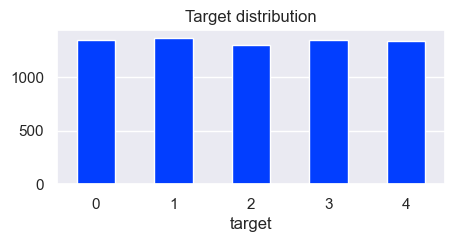

In [16]:
plt.figure(figsize=(5, 2)) # set the size of the graph 
ax = df.target.value_counts().sort_index().plot(kind='bar', title='Target distribution', rot=0) # plot the graph
ax.yaxis.grid(True) # show horizontal grid
plt.show() # show the graph

In [17]:
# check the number of missing values and constant features in the dataframe
print(f'the number of missing values: {df.isna().sum().sum()}')
df.nunique().sort_values()[:3] # check the number of unique values in each column

the number of missing values: 0


target        5
rolloff    5490
zcr        6206
dtype: int64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df.target, test_size=0.1, shuffle=True, random_state=42) # split the dataframe into train and test sets
features = X_train.columns.tolist() # create a list of features
X_train.shape, X_test.shape # check the shape of the train and test sets    

((6043, 217), (672, 217))

In [19]:
class DropDupCorrScal(BaseEstimator, TransformerMixin):
    '''
    the class drops duplicate and correlated features
    '''
    def __init__(self, threshold=0.8):
        '''
        threshold: threshold for dropping correlated features
        '''
        self.threshold = threshold
        self.drop_dup = DropDuplicateFeatures(variables=None, missing_values='raise') # initialize the transformer for dropping duplicate features
        self.drop_corr = SmartCorrelatedSelection(variables=None, method='pearson',
                                                  threshold=threshold, missing_values='raise',
                                                  selection_method='variance') # initialize the transformer for dropping correlated features
    def fit(self, X, y=None):
        '''
        the function fits the transformer
        X: features
        y: target
        return: self
        '''
        self.drop_dup.fit(X) # fit the transformer for dropping duplicate features
        self.drop_corr.fit(X) # fit the transformer for dropping correlated features    
        return self

    def transform(self, X, y=None):
        '''
        the function transforms the features
        X: features
        y: target
        return: transformed features
        '''
 
        X = self.drop_dup.transform(X) # drop duplicate features
        X = self.drop_corr.transform(X) # drop correlated features
        return X

In [20]:
processor = DropDupCorrScal() # initialize the transformer
X_train, X_test = processor.fit_transform(X_train), processor.transform(X_test) # transform the features   
X_train.shape, X_test.shape # check the shape of the train and test sets

((6043, 110), (672, 110))

In [21]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()), # initialize the transformer for scaling features
    ('model', LogisticRegression(multi_class='multinomial', random_state=42))
    ]) # initialize the pipeline

# Define the parameter grid
param_grid = {
    'model__C': [*range(10, 100, 10)],
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none '],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],

}

# Create the grid search object
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

model = grid_search.best_estimator_ # save the best model

Best parameters: {'model__C': 90, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best score: 0.9496928390273828


In [22]:
# Calculate the accuracy score
accuracy_score(y_test, model.predict(X_test))

0.9494047619047619

In [23]:
from joblib import dump, load # to save and load the model
dump(model, 'model.joblib') # save the model

['model.joblib']

In [24]:
model = load('model.joblib') # load the model
model

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=90, multi_class='multinomial',
                                    random_state=42, solver='newton-cg'))])

---
##### *__Train neural network model for voice command classification with PyTorch__*
---

*__Logistic Regression with PyTorch :__*

In [25]:
scaler = MinMaxScaler() # initialize the transformer for scaling features
scaler.fit(X_train) # fit the transformer
# join the train and test sets and convert them to tensors
data_x = torch.from_numpy(scaler.transform(pd.concat([X_train, X_test]))).type(torch.FloatTensor)
data_y = torch.from_numpy(np.concatenate((y_train, y_test))).type(torch.LongTensor)
# split the dataset into train and test sets
train_x, val_x, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2, shuffle=False, random_state=42)
train_x.shape, val_x.shape, train_y.shape, val_y.shape # check the shape of the train and test sets

(torch.Size([5372, 110]),
 torch.Size([1343, 110]),
 torch.Size([5372]),
 torch.Size([1343]))

In [26]:
class AudioDataset(Dataset):
    '''
    the class creates a custom dataset of tensors
    '''
    def __init__(self, X, y, transform=None):
        '''
        X: features
        y: target
        '''
        self.X = X
        self.y = y

    def __len__(self):
        '''
        the function returns the length of the dataset
        '''
        return len(self.X)

    def __getitem__(self, idx):
        '''
        the function returns a sample from the dataset
        idx: index of the sample
        return: sample
        '''
        return self.X[idx], self.y[idx]

In [27]:
train_data = AudioDataset(train_x, train_y) # create a dataset
print(train_data[0][0].size(),train_data[0][0].type(), train_data[0][1].type(), len(train_data)) # check the first sample
train_loader = DataLoader(train_data, batch_size=100, shuffle=True) # create a dataloader

val_data = AudioDataset(val_x, val_y) # create a dataset 
print(val_data[0][0].size(), val_data[0][1].type(), len(val_data)) # check the first sample
val_loader = DataLoader(val_data, batch_size=100, shuffle=True) # create a dataloader

torch.Size([110]) torch.FloatTensor torch.LongTensor 5372
torch.Size([110]) torch.LongTensor 1343


In [32]:
in_size, out_size = train_data[0][0].size()[0], np.unique(data_y).size # get the input and output sizes
print(f'number of parameters: {in_size}\nnumber of classes: {out_size}')
model = nn.Linear(in_size, out_size) # create a model
criterion = nn.CrossEntropyLoss() # create a loss function
optimizer = optim.SGD(model.parameters(), lr=1) # create an optimizer    
epochs = 5000 # set the number of epochs

LOSS, accuracy = {'train': [], 'val': []}, [] # create a list for the loss

number of parameters: 110
number of classes: 5


In [33]:
for epoch in range(epochs):
    lst, total, correct = [], 0, 0 # create a list for the loss, total number of samples and correct predictions

    for x, y in train_loader: # iterate over the train loader
        optimizer.zero_grad() # zero the gradients
        loss = criterion(model(x), y) # calculate the loss
        loss.backward() # backpropagate the loss
        optimizer.step() # update the weights
        lst.append(loss.item()) # append the loss to the list
    if epoch % 200 == 0: # grab the loss every 200 epochs
        LOSS['train'].append(sum(lst)/len(lst)) # calculate the average loss
        lst = [] # clean the list

    for x, y in val_loader: # calculate the loss on the validation set
        lst.append(criterion(model(x), y).item()) # calculate the loss
        _, predicted = torch.max(model(x).data, 1) # get the predictions
        total += y.size(0) # update the total number of samples
        correct += (predicted == y).sum().item() # update the correct predictions
    if epoch % 200 == 0: # grab the loss every 200 epochs
        LOSS['val'].append(sum(lst)/len(lst)) # calculate the average loss
        accuracy.append(correct / total)  # append calculated the accuracy

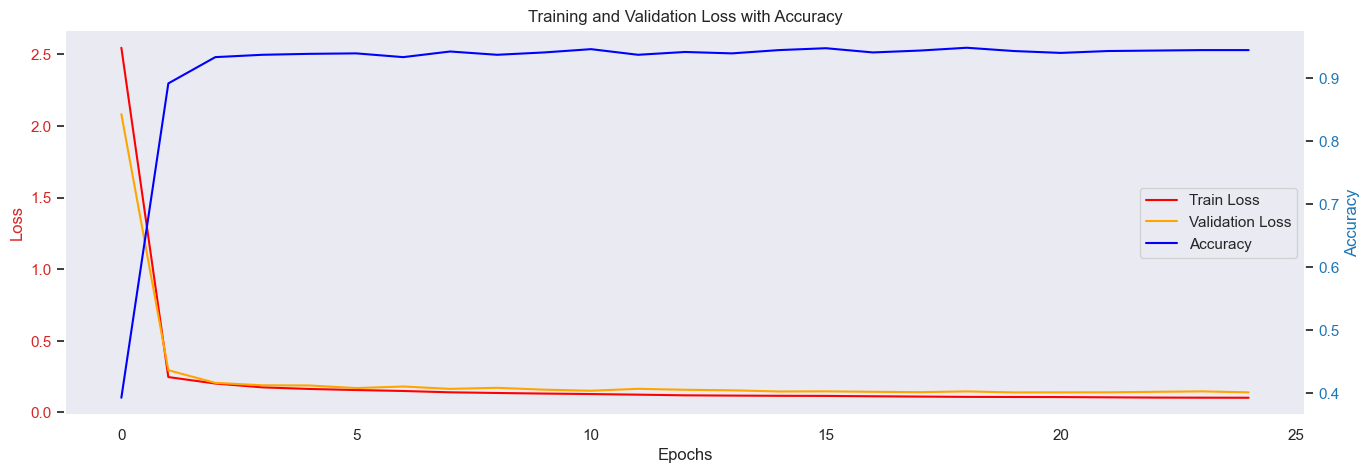

In [34]:
# Create a dataframe for the loss values
df_loss = pd.DataFrame({'Train Loss': LOSS['train'], 'Validation Loss': LOSS['val']})

# Create a dataframe for the accuracy values
df_accuracy = pd.DataFrame({'Accuracy': accuracy})

# Plot the loss and accuracy values
fig, ax1 = plt.subplots(figsize=(16, 5)) # set the size of the graph 

# Plot the loss values
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(df_loss.index, df_loss['Train Loss'], color='red', label='Train Loss')
ax1.plot(df_loss.index, df_loss['Validation Loss'], color='orange', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for accuracy
ax2 = ax1.twinx()

# Plot the accuracy values
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(df_accuracy.index, df_accuracy['Accuracy'], color='blue', label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Create a common legend and place it in the middle from the right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.title('Training and Validation Loss with Accuracy')
plt.show()


In [35]:
accuracy[-1]

0.9441548771407298

*__Nueral Network :__*

In [36]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=10):
    """
    the function accepts the model, loss function, train and validation loaders, optimizer and number of epochs
    model: neural network model
    criterion: loss function
    train_loader: train loader
    validation_loader: validation loader
    optimizer: optimizer
    epochs: number of epochs
    """
    metrics = {'training_loss': [],'validation_accuracy': []} # create a dictionary for the loss and accuracy values
    for epoch in range(epochs): # iterate over the epochs
        total_loss = 0 # initialize the loss
        for x, y in train_loader: # iterate over the train loader
            optimizer.zero_grad() # zero the gradients
            loss = criterion(model(x), y) # calculate the loss
            loss.backward() # backpropagate the loss
            optimizer.step() # update the weights
            total_loss += loss.data.item() # update the loss for every iteration

        metrics['training_loss'].append(total_loss / len(train_loader)) # calculate the average loss
        correct = 0 # initialize the correct predictions

        for x, y in validation_loader: # iterate over the validation loader
            _, label = torch.max(model(x), 1) # get the predictions
            correct += (label == y).sum().item() # update the correct predictions

        accuracy = 100 * (correct / len(validation_loader.dataset)) # calculate the accuracy
        metrics['validation_accuracy'].append(accuracy) # append the accuracy to the list
        
    return metrics

In [38]:
# create nueral networks
hidden_size = 5
model = nn.Sequential(
    nn.Linear(110, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, 5)
)
criterion = nn.CrossEntropyLoss() # create a loss function 
optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

In [39]:
metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=100) # train the model

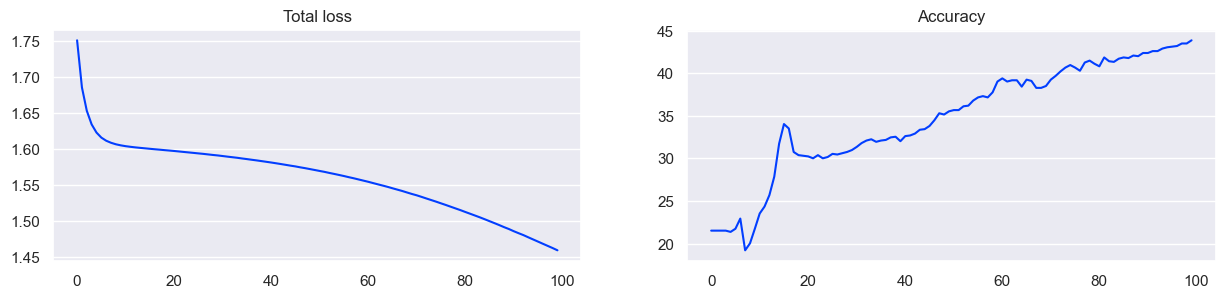

In [41]:
fig = plt.figure(figsize=(15, 3)) # set the size of the graph
plt.subplot(1, 2, 1) # create a subplot
plt.plot(metrics['training_loss']) # plot the loss
plt.title('Total loss') # set the title
plt.grid(axis='y') # show horizontal grid

plt.subplot(1, 2, 2) # create a subplot
plt.plot(metrics['validation_accuracy']) # plot the accuracy
plt.title("Accuracy") # set the title
plt.grid(axis='y') # show horizontal grid

plt.show() # show the graph

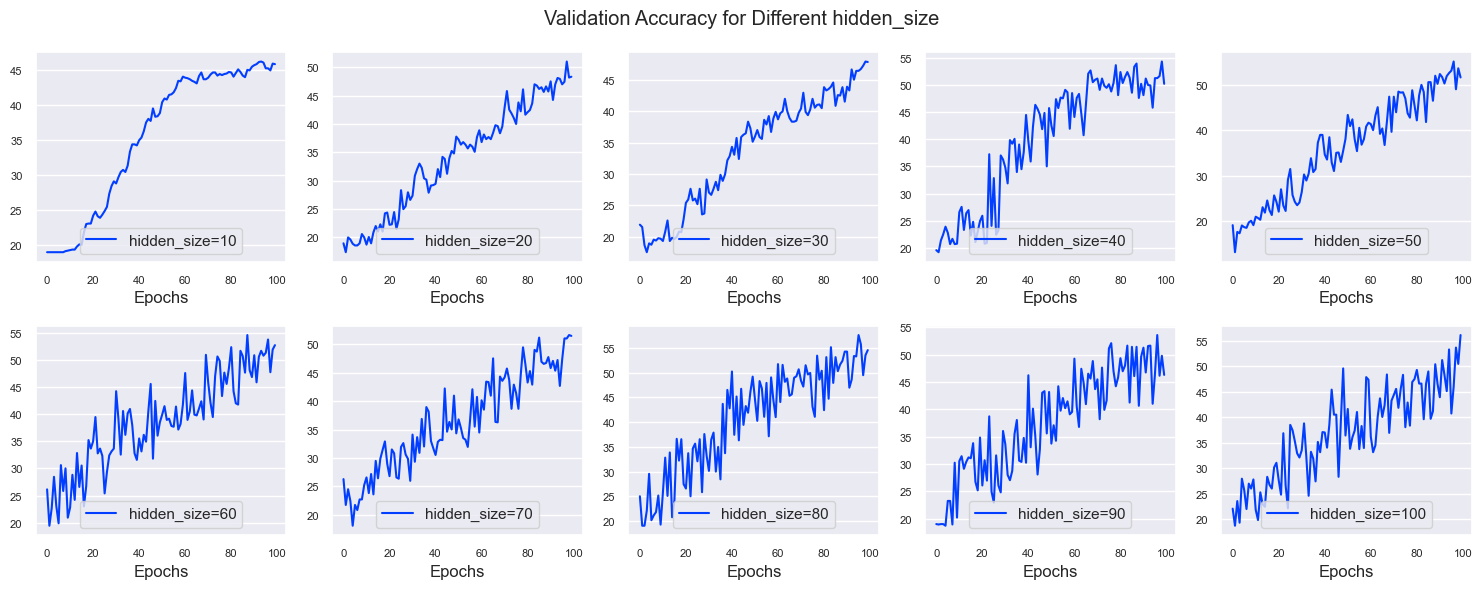

In [49]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) # set the size of the graph
fig.suptitle('Validation Accuracy for Different hidden_size') # set the title

for i, ax in enumerate(axes.flatten()): # iterate over the subplots
    hidden_size = (i + 1) * 10 # set the hidden size
    # create nueral networks
    model = nn.Sequential(
        nn.Linear(110, hidden_size),
        nn.Sigmoid(),
        nn.Linear(hidden_size, 5)
    )
    criterion = nn.CrossEntropyLoss() # create a loss function 
    optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

    metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=100) # train the model
    
    ax.plot(metrics['validation_accuracy'], label=f'hidden_size={hidden_size}') # plot the accuracy
    ax.set_xlabel('Epochs') # set the label for the x-axis
    ax.legend(loc='lower center') # show the legend
    ax.grid(axis='y')  # Add horizontal grid
    ax.tick_params(axis='both', which='both', labelsize=8)  # Set tick label size

plt.tight_layout() # set the layout of the graph
plt.show() # show the graph

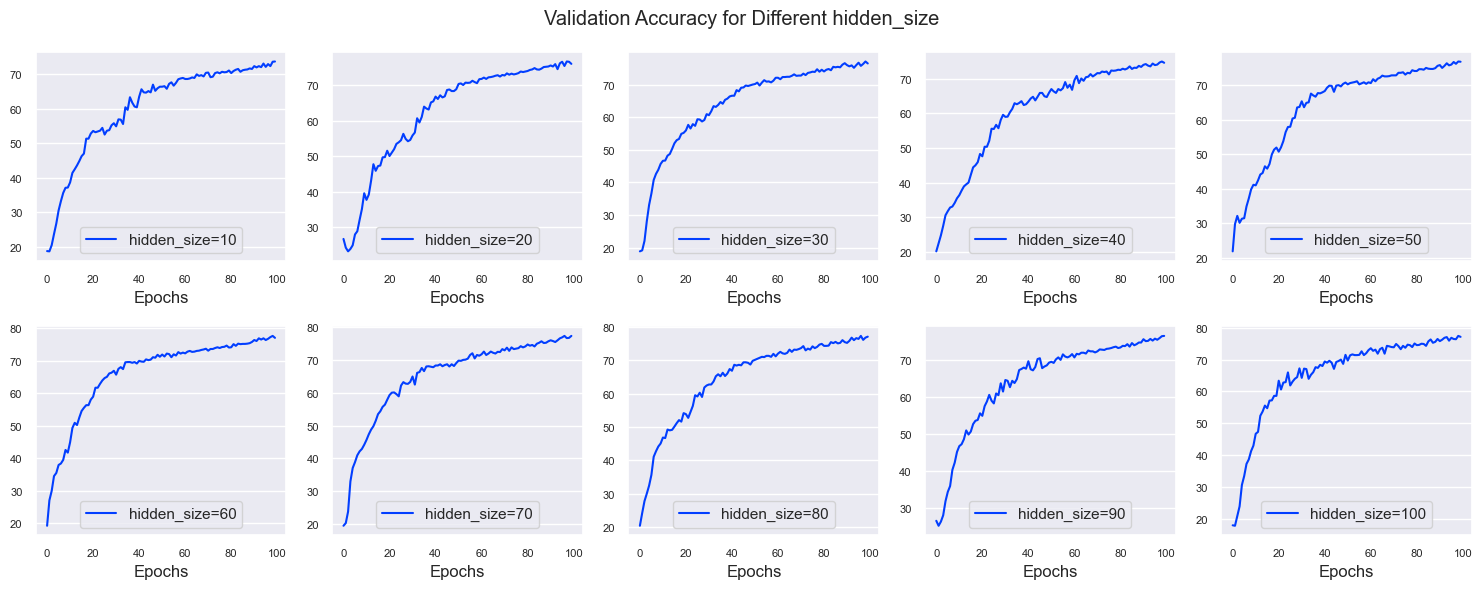

In [50]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) # set the size of the graph 
fig.suptitle('Validation Accuracy for Different hidden_size') # set the title

for i, ax in enumerate(axes.flatten()): # iterate over the subplots
    hidden_size = (i + 1) * 10 # set the hidden size
    # create nueral networks
    model = nn.Sequential(
        nn.Linear(110, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 5)
    )
    criterion = nn.CrossEntropyLoss() # create a loss function 
    optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

    metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=100) # train the model
    
    ax.plot(metrics['validation_accuracy'], label=f'hidden_size={hidden_size}') # plot the accuracy
    ax.set_xlabel('Epochs') # set the label for the x-axis
    ax.legend(loc='lower center') # show the legend
    ax.grid(axis='y')  # Add horizontal grid
    ax.tick_params(axis='both', which='both', labelsize=8)  # Set tick label size

plt.tight_layout() # set the layout of the graph
plt.show() # show the graph

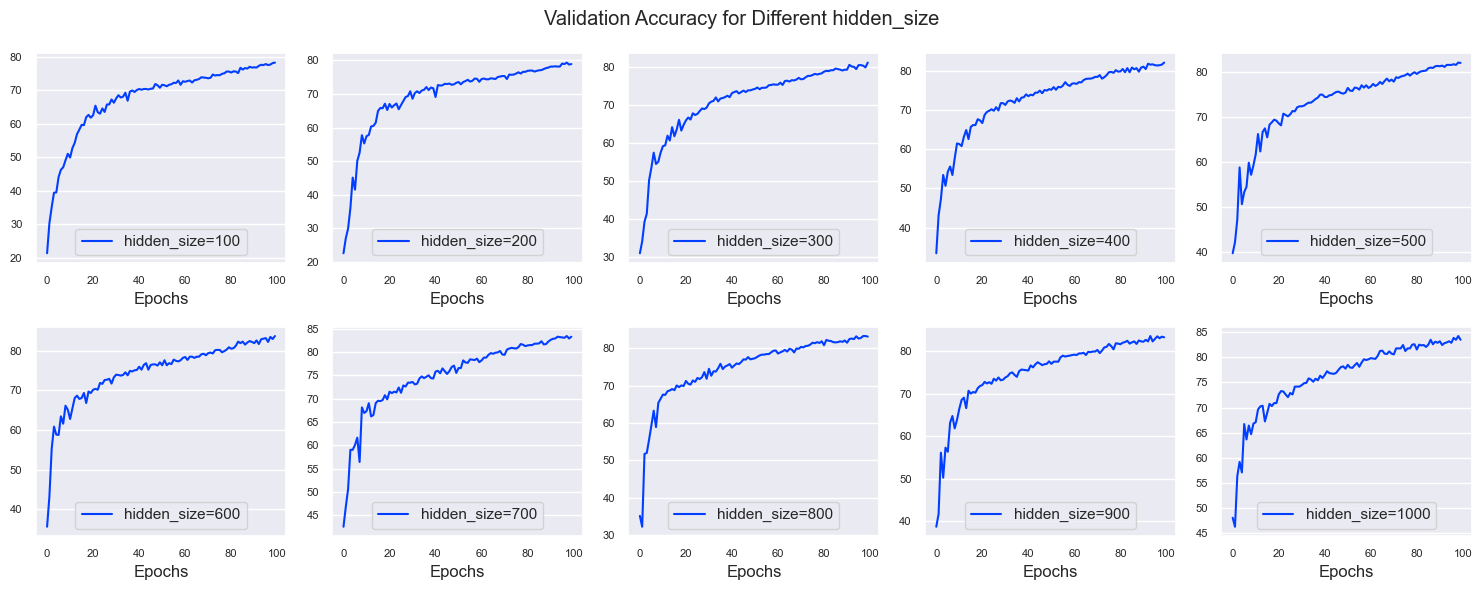

In [51]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) # set the size of the graph
fig.suptitle('Validation Accuracy for Different hidden_size') # set the title

for i, ax in enumerate(axes.flatten()): # iterate over the subplots
    hidden_size = (i + 1) * 100 # set the hidden size
    # create nueral networks
    model = nn.Sequential(
        nn.Linear(110, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, 5)
    )
    criterion = nn.CrossEntropyLoss() # create a loss function 
    optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

    metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=100) # train the model
    
    ax.plot(metrics['validation_accuracy'], label=f'hidden_size={hidden_size}') # plot the accuracy
    ax.set_xlabel('Epochs') # set the label for the x-axis
    ax.legend(loc='lower center') # show the legend
    ax.grid(axis='y')  # Add horizontal grid
    ax.tick_params(axis='both', which='both', labelsize=8)  # Set tick label size

plt.tight_layout() # set the layout of the graph
plt.show() # show the graph


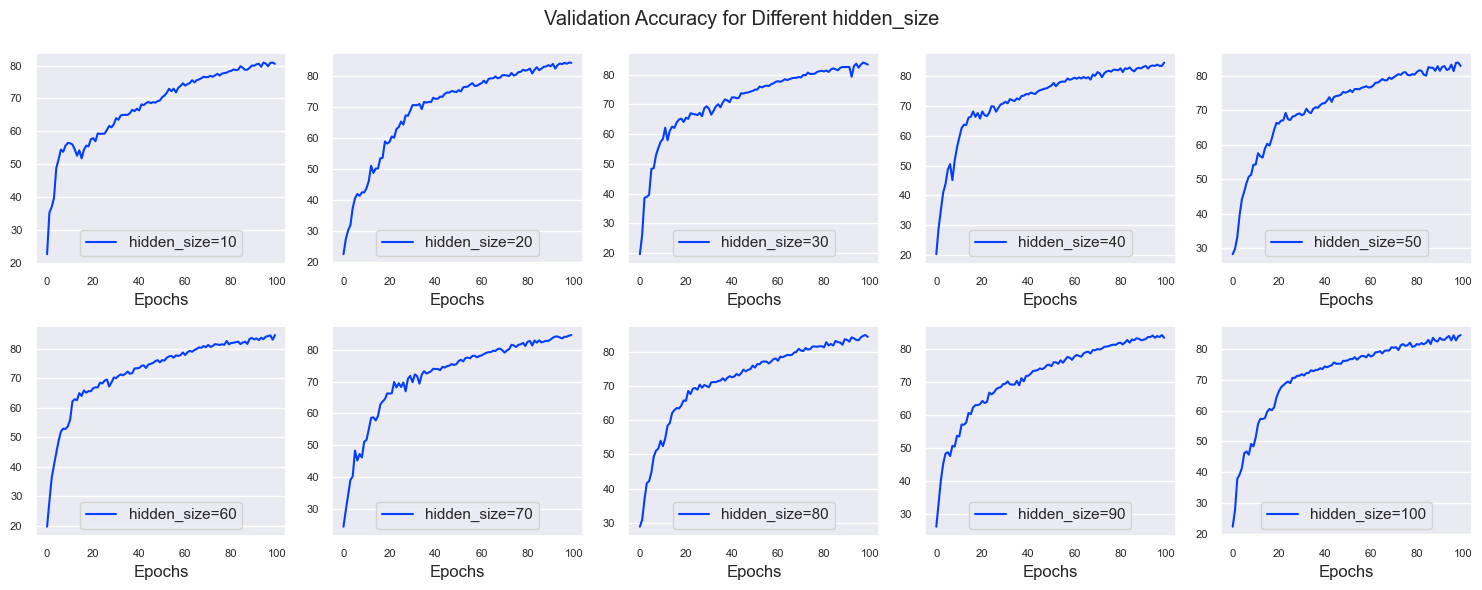

In [52]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Validation Accuracy for Different hidden_size')

for i, ax in enumerate(axes.flatten()):
    hidden_size = (i + 1) * 10
    model = nn.Sequential(
        nn.Linear(110, 500),
        nn.Tanh(),
        nn.Linear(500, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, 5)
    )
    criterion = nn.CrossEntropyLoss() # create a loss function 
    optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

    metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=100)
    
    ax.plot(metrics['validation_accuracy'], label=f'hidden_size={hidden_size}')
    ax.set_xlabel('Epochs')
    ax.legend(loc='lower center')
    ax.grid(axis='y')  # Add horizontal grid
    ax.tick_params(axis='both', which='both', labelsize=8)  # Set tick label size

plt.tight_layout()
plt.show()


tensor([-0.0823,  0.0605,  0.0117, -0.0878,  0.0287, -0.0174,  0.0308, -0.0807,
         0.0268, -0.0396])


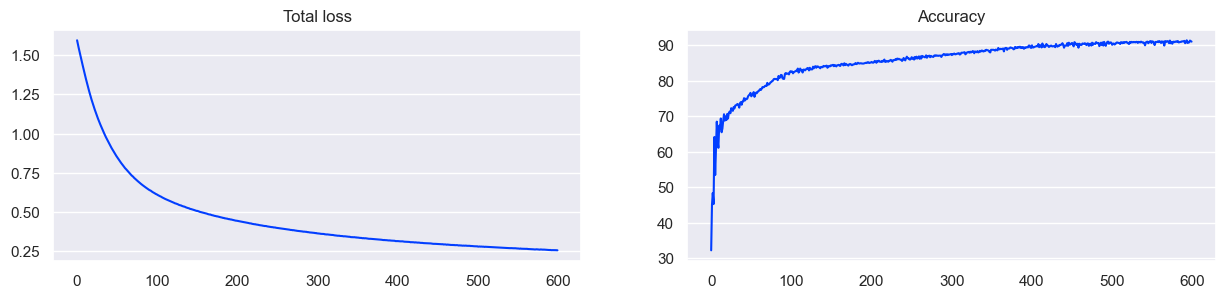

90.9903201787044
tensor([-0.0753,  0.0625,  0.0319, -0.0590,  0.0482, -0.0179,  0.0454, -0.0908,
         0.0228, -0.0562])


In [69]:
# create nueral networks
model = nn.Sequential(
    nn.Linear(110, 500),
    nn.Tanh(),
    nn.Linear(500, 5)
)
print(model.state_dict()['0.weight'][0][:10])
criterion = nn.CrossEntropyLoss() # create a loss function 
optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=600)

fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(metrics['training_loss'])
plt.title('Total loss')
plt.grid(axis='y')  
plt.subplot(1, 2, 2)
plt.plot(metrics['validation_accuracy'])
plt.title("Accuracy")
plt.grid(axis='y')
plt.show()

print(metrics['validation_accuracy'][-1])
print(model.state_dict()['0.weight'][0][:10])

In [70]:
import pickle

# Save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [71]:
model.state_dict()['0.weight'][0][:10]

tensor([-0.0753,  0.0625,  0.0319, -0.0590,  0.0482, -0.0179,  0.0454, -0.0908,
         0.0228, -0.0562])

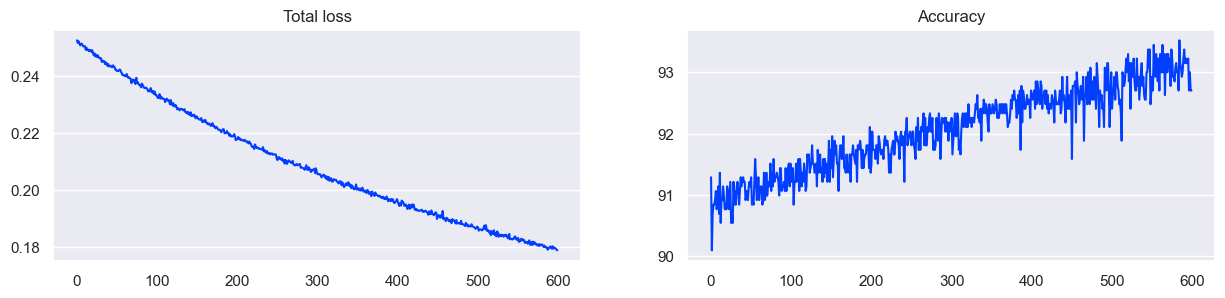

92.70290394638869


In [66]:
criterion = nn.CrossEntropyLoss() # create a loss function 
optimizer = optim.SGD(model.parameters(), lr=.01) # create an optimizer

metrics = train(model, criterion, train_loader, val_loader, optimizer, epochs=600)

fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(metrics['training_loss'])
plt.title('Total loss')
plt.grid(axis='y')  
plt.subplot(1, 2, 2)
plt.plot(metrics['validation_accuracy'])
plt.title("Accuracy")
plt.grid(axis='y')
plt.show()

print(metrics['validation_accuracy'][-1])